### Test Corr Models

In [241]:
import numpy as np
import pandas as pd
from copy import deepcopy
import yfinance as yf

import dynamic_correlations as CM
import expected_shortfall as ES
import backtesting as BT
import plots as IP

### Data 

In [242]:
# Step 1: Download prices
tickers = ["^GSPC", "^STOXX50E", "^N225"]
data = yf.download(tickers, start="2015-01-01", end="2025-01-01")["Close"]
data = data.dropna()

# Step 2: Define fixed quantities
quantities = pd.Series([10, 80, -10], index=tickers)

# Step 3: Compute monetary positions
x_matrix = data.multiply(quantities, axis=1)

[*********************100%***********************]  3 of 3 completed


In [243]:
x_matrix.head()

,^GSPC,^N225,^STOXX50E
Date,,,
2015-01-05,20205.799561,-174087.109375,241851.191406
2015-01-07,20259.000244,-168853.300781,242143.203125
2015-01-08,20621.398926,-171670.996094,250806.406250
2015-01-09,20448.100586,-171977.304688,243431.992188
2015-01-13,20230.300293,-170877.109375,250708.808594


In [244]:
# Run MA Correlation VaR
x_ma = deepcopy(x_matrix)
result_ma= CM.var_corr_moving_average(x_ma, window_size=20)

# Run RiskMetrics Correlation VaR
x_rm = deepcopy(x_matrix)
result_rm = CM.var_corr_ewma(x_rm)


In [245]:
result_ma.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2015-02-05,0.011934,0.039099,0.090958,10759.944270,False
2015-02-06,-0.020550,0.039693,0.092340,10704.271652,False
2015-02-09,-0.042247,0.040634,0.094529,10508.587323,False
2015-02-10,0.031980,0.035356,0.082250,9443.122455,False
2015-02-12,-0.003001,0.032139,0.074767,8560.501980,False


In [246]:
result_rm.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2015-01-07,0.057961,0.035568,0.082744,7740.596687,False
2015-01-08,0.064931,0.036868,0.085767,8555.854591,False
2015-01-09,-0.083091,0.043050,0.100148,9203.903020,False
2015-01-13,0.083668,0.044227,0.102887,10295.053241,False
2015-01-14,-0.007396,0.042614,0.099135,9846.716517,False


In [247]:
# Apply volatility-based ES to the MA VaR result
result_ma = ES.es_correlation(result_ma, confidence_level=0.99)

# Same for RiskMetrics
result_rm = ES.es_correlation(result_rm, confidence_level=0.99)


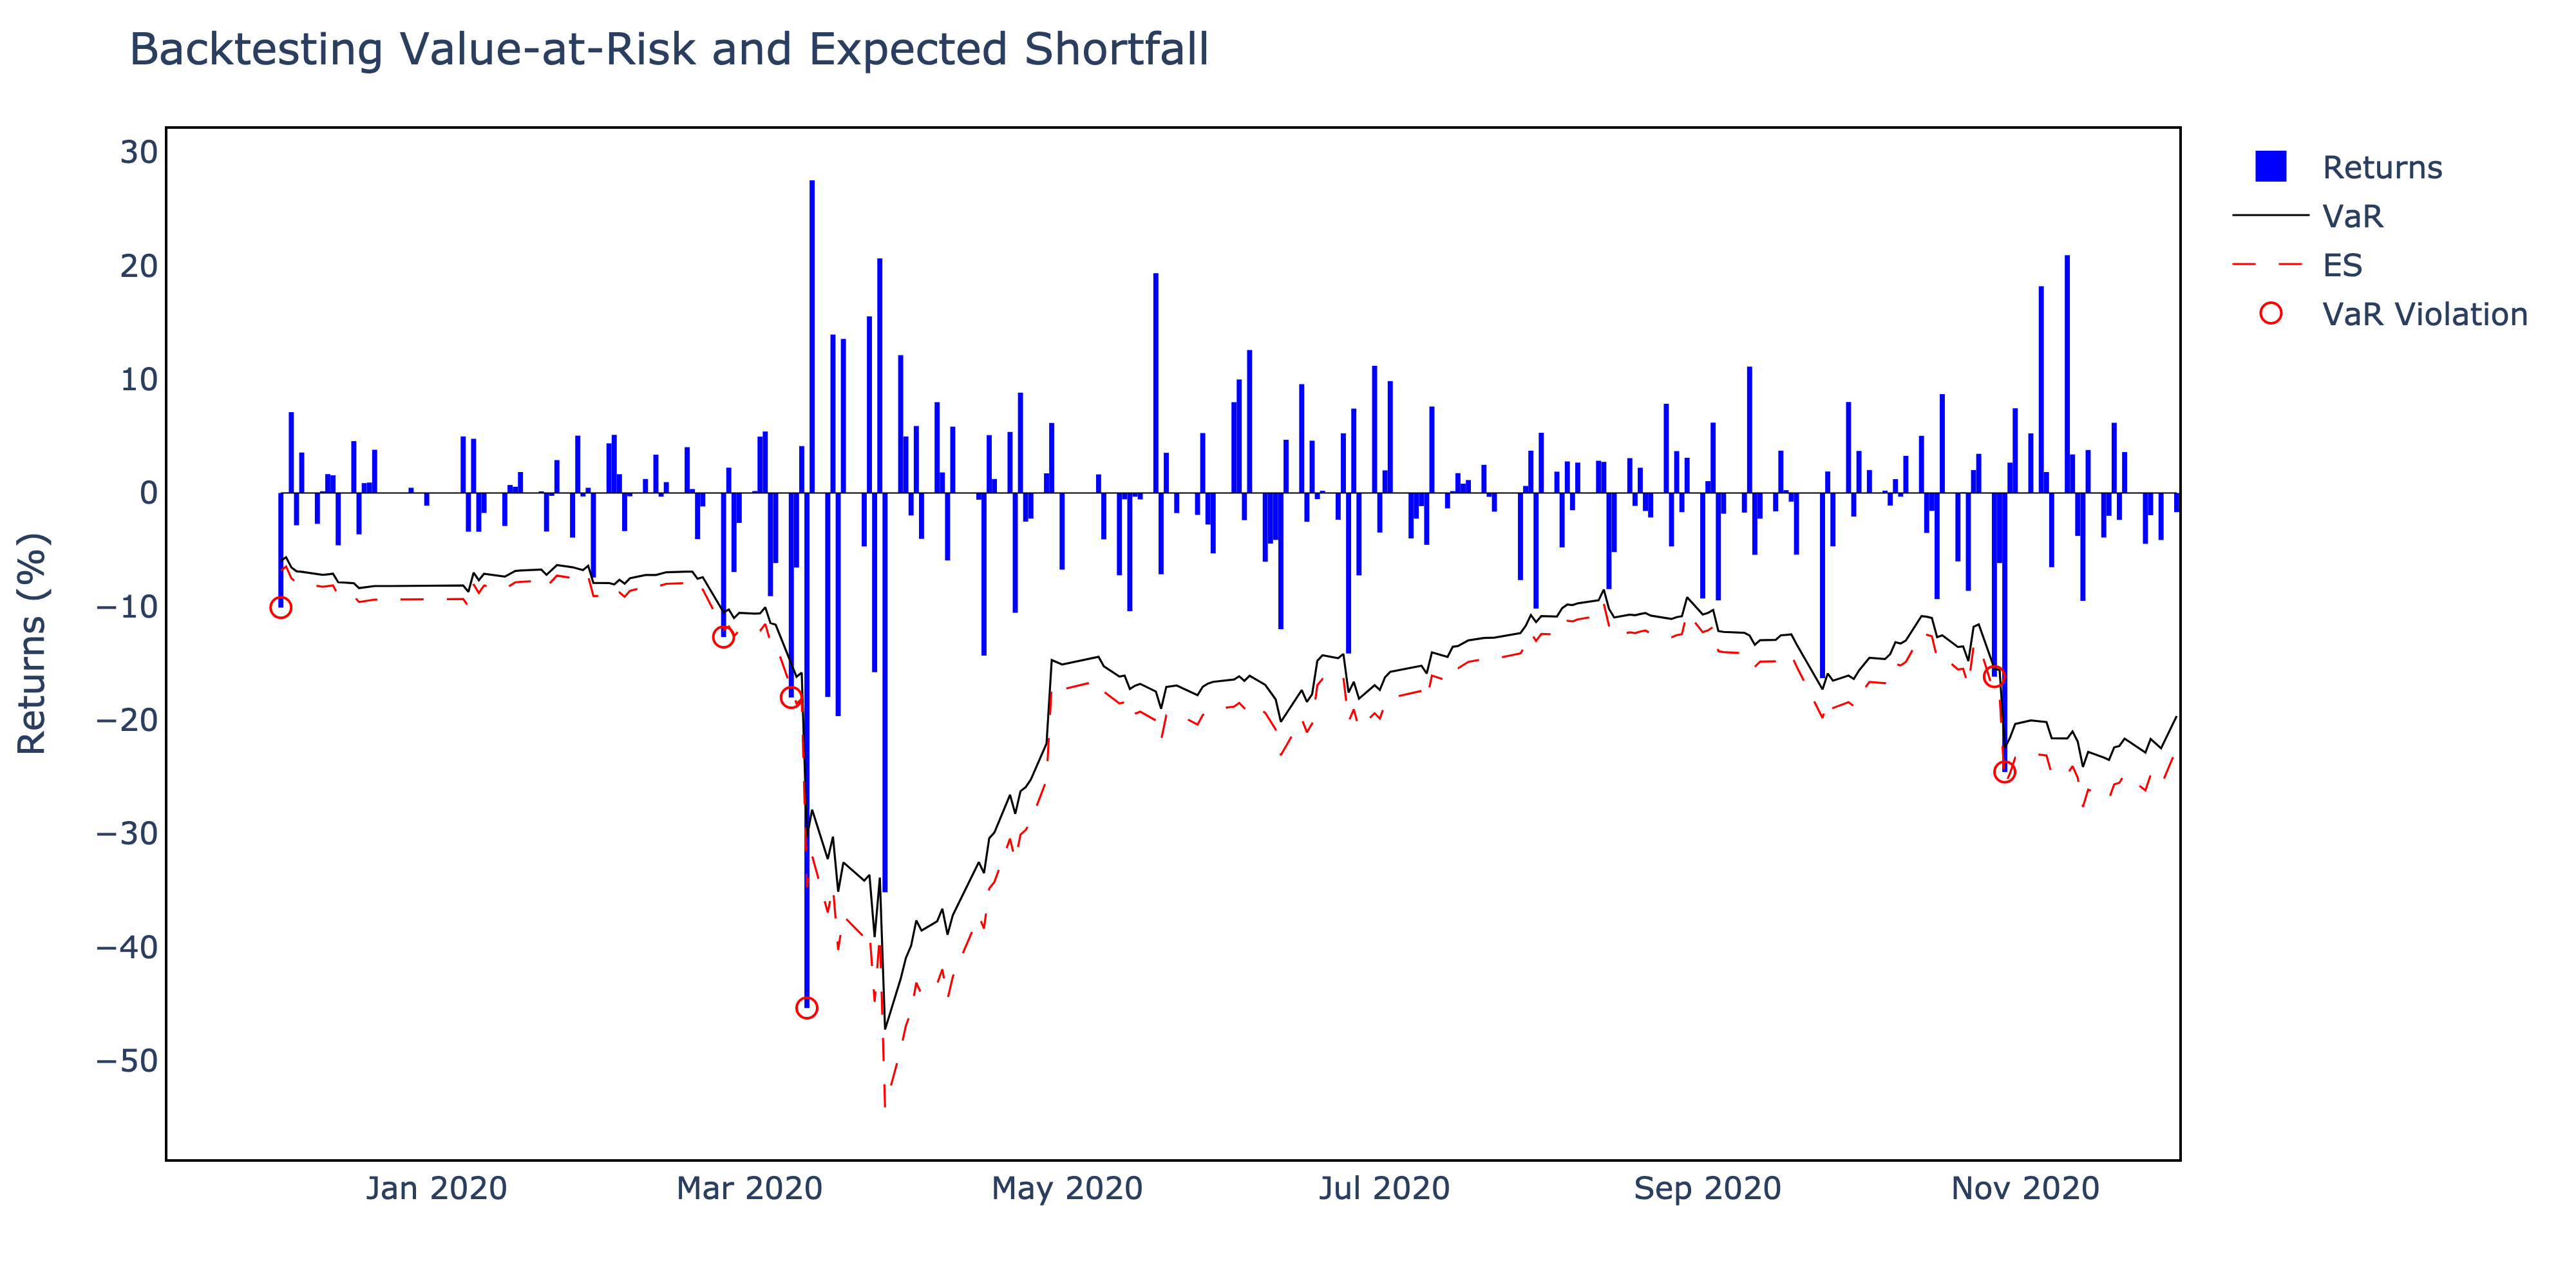


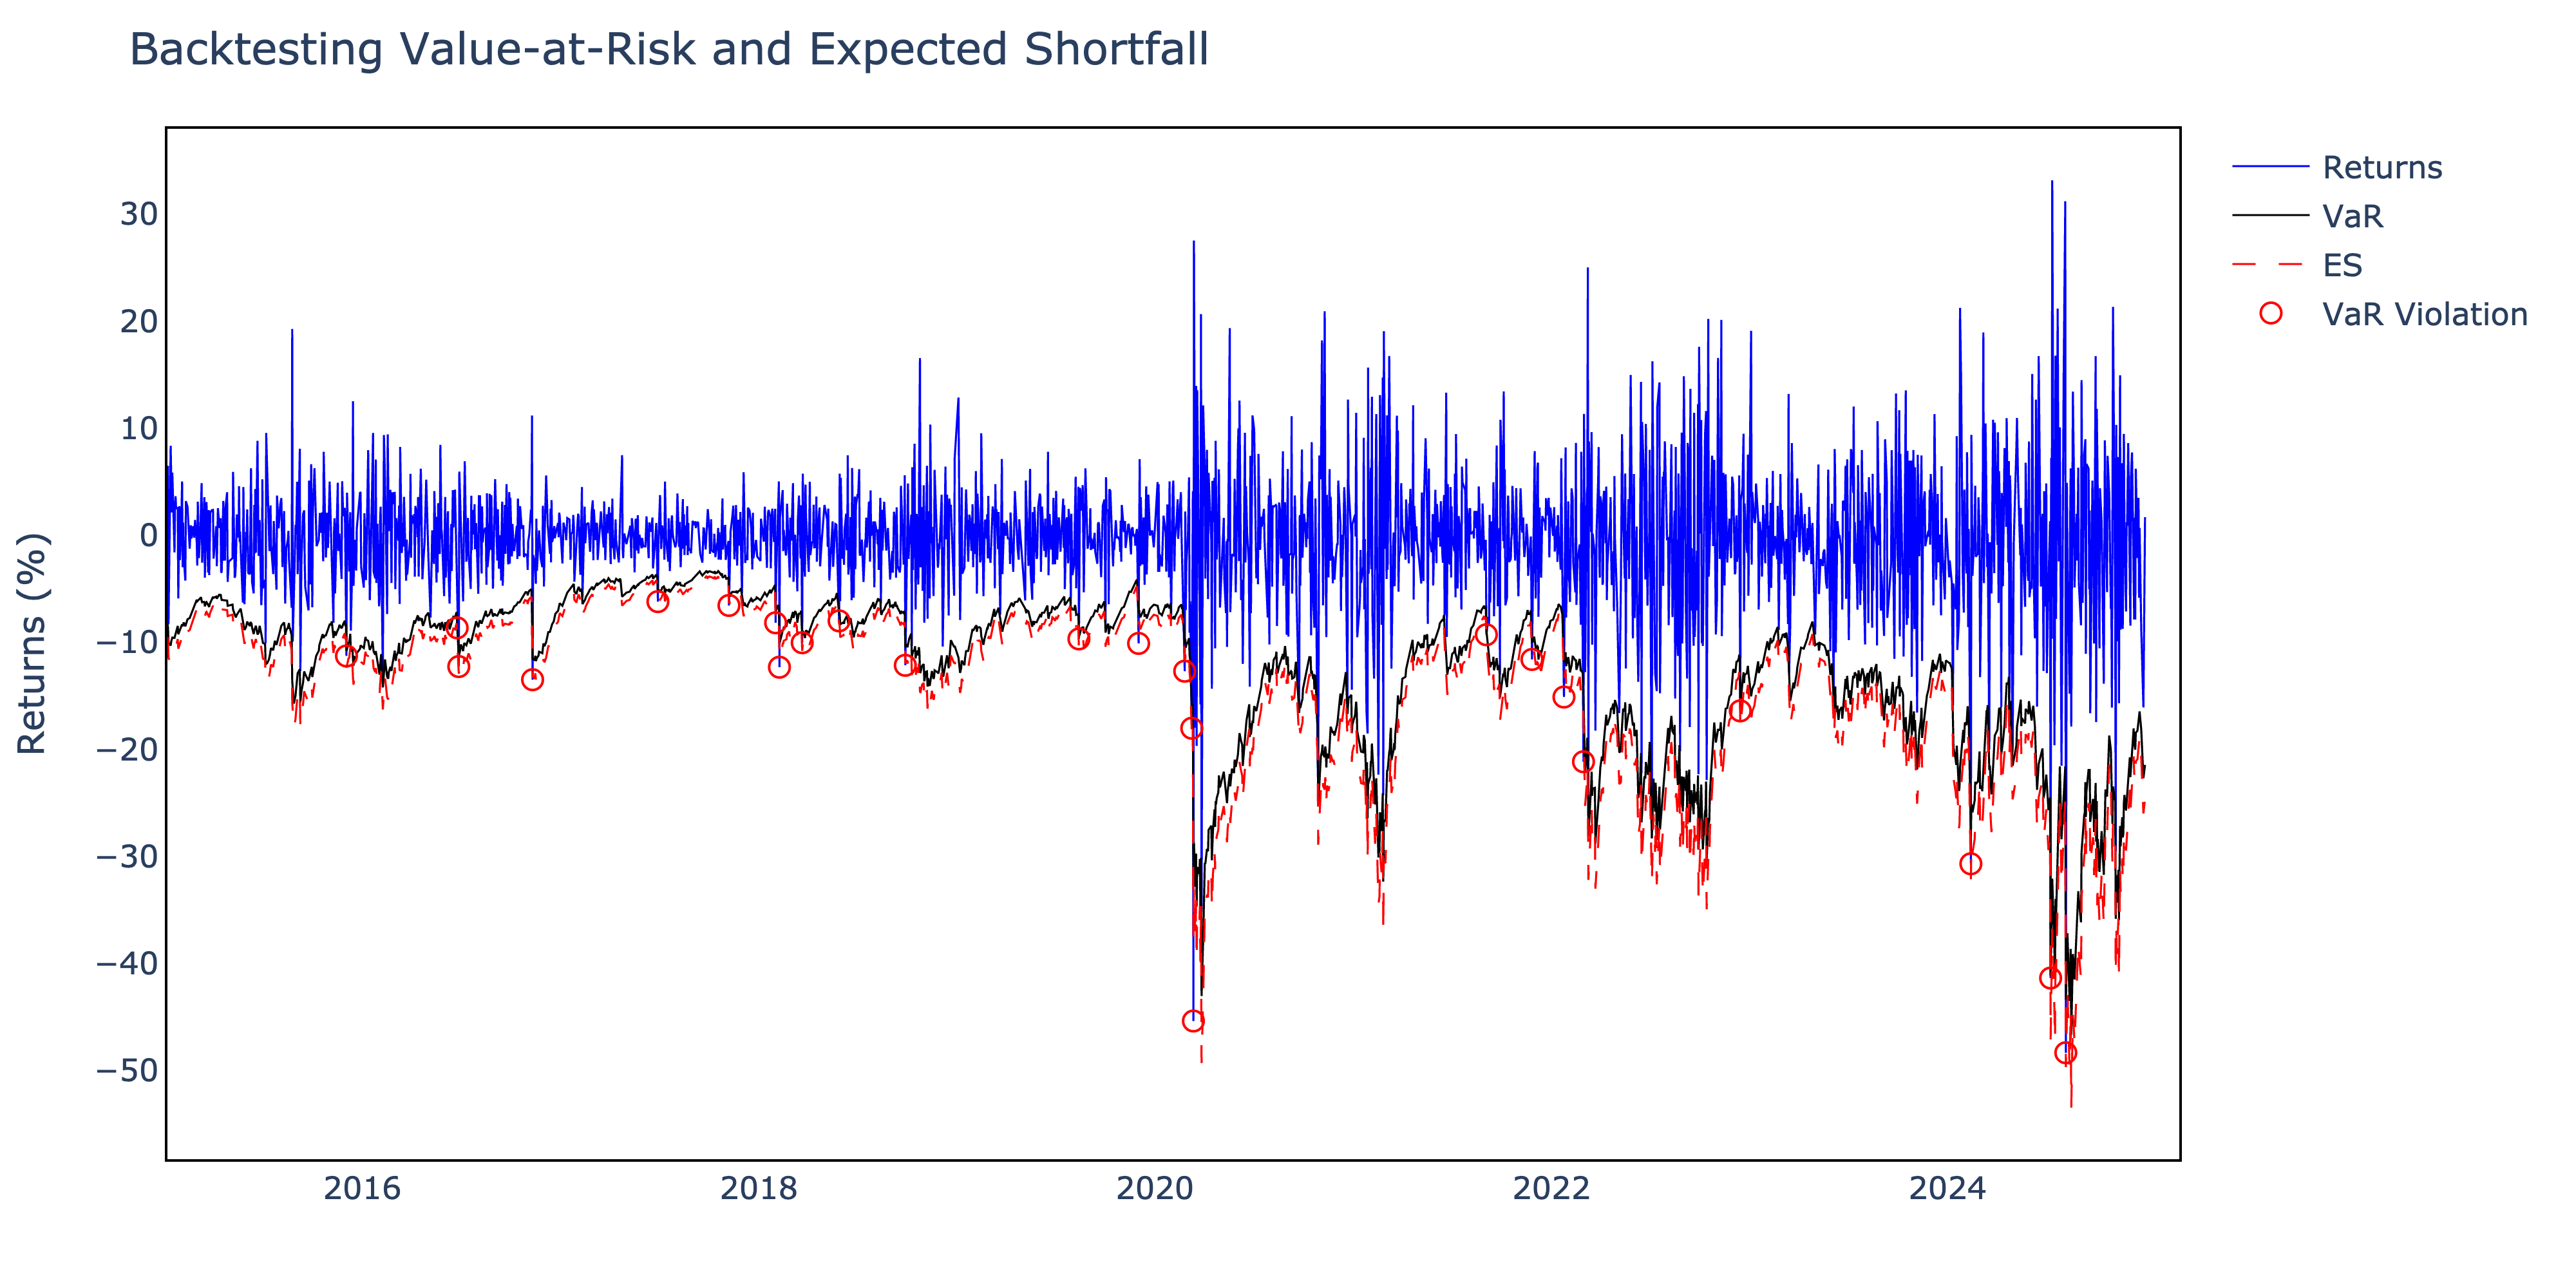

In [248]:
# Plot MA model results
fig_ma_es = IP.plot_backtest(result_ma, subset=("2019-11-30", "2020-11-30"), interactive=False)

# Plot RiskMetrics model results
fig_rm_es = IP.plot_backtest(result_rm, interactive=False)


In [249]:
violations_ma, rate_ma = BT.count_violations(result_ma)

print("== MA Correlation VaR Backtest ==")
print(f"Total Violations: {violations_ma}")
print(f"Violation Rate: {rate_ma:.2f}%")

== MA Correlation VaR Backtest ==
Total Violations: 36
Violation Rate: 1.57%


In [250]:
violations_rm, rate_rm = BT.count_violations(result_rm)

print("== RiskMetrics Correlation VaR Backtest ==")
print(f"Total Violations: {violations_rm}")
print(f"Violation Rate: {rate_rm:.2f}%")

== RiskMetrics Correlation VaR Backtest ==
Total Violations: 24
Violation Rate: 1.04%


In [251]:
fig_ma_vol = IP.plot_volatility(result_ma["Volatility"])
fig_rm_vol = IP.plot_volatility(result_rm["Volatility"])

### Bakctesting 

In [252]:
# 1. Recompute monetary positions (already done)
x_rm = deepcopy(x_matrix)

# 2. Run RiskMetrics Correlation VaR
result_rm = CM.var_corr_ewma(x_rm)

# 3. Count violations
total_violations, violation_rate = BT.count_violations(result_rm)

# 4. Run Kupiec test
confidence_level = 0.99  # adjust if needed
kupiec_results = BT.kupiec_test(total_violations, len(result_rm), confidence_level)

# 5. Run Christoffersen test
christoffersen_results = BT.christoffersen_test(result_rm)

# 6. Joint test
joint_results = BT.joint_lr_test(
    LR_uc=kupiec_results["LR_uc"],
    LR_c=christoffersen_results["LR_c"]
)


In [253]:
print("=== VaR Backtesting Summary ===")
print(f"Total Violations: {total_violations}")
print(f"Violation Rate: {violation_rate:.2f}%")

print("\n-- Kupiec Test --")
for k, v in kupiec_results.items():
    print(f"{k}: {v}")

print("\n-- Christoffersen Test --")
for k, v in christoffersen_results.items():
    print(f"{k}: {v}")

print("\n-- Joint Test --")
for k, v in joint_results.items():
    print(f"{k}: {v}")


=== VaR Backtesting Summary ===
Total Violations: 24
Violation Rate: 1.04%

-- Kupiec Test --
LR_uc: 0.033416128879196094
p_value: 0.8549543286094071
reject_null: False

-- Christoffersen Test --
LR_c: 1.3253611747419427
p_value: 0.24963214923443944
reject_null: False

-- Joint Test --
LR_total: 1.3587773036211388
p_value: 0.5069268064390942
reject_null: False


In [254]:
# 1. Recompute monetary positions (already done)
x_rm = deepcopy(x_matrix)

# 2. Run RiskMetrics Correlation VaR
result_rm = CM.var_corr_ewma(x_rm)

# 3. Count violations
total_violations, violation_rate = BT.count_violations(result_ma)

# 4. Run Kupiec test
confidence_level = 0.99  # adjust if needed
kupiec_results = BT.kupiec_test(total_violations, len(result_ma), confidence_level)

# 5. Run Christoffersen test
christoffersen_results = BT.christoffersen_test(result_ma)

# 6. Joint test
joint_results = BT.joint_lr_test(
    LR_uc=kupiec_results["LR_uc"],
    LR_c=christoffersen_results["LR_c"]
)


In [255]:
print("=== VaR Backtesting Summary ===")
print(f"Total Violations: {total_violations}")
print(f"Violation Rate: {violation_rate:.2f}%")

print("\n-- Kupiec Test --")
for k, v in kupiec_results.items():
    print(f"{k}: {v}")

print("\n-- Christoffersen Test --")
for k, v in christoffersen_results.items():
    print(f"{k}: {v}")

print("\n-- Joint Test --")
for k, v in joint_results.items():
    print(f"{k}: {v}")


=== VaR Backtesting Summary ===
Total Violations: 36
Violation Rate: 1.57%

-- Kupiec Test --
LR_uc: 6.4126403706945325
p_value: 0.011331079871047534
reject_null: True

-- Christoffersen Test --
LR_c: 2.3027290288385984
p_value: 0.12914691270476863
reject_null: False

-- Joint Test --
LR_total: 8.715369399533131
p_value: 0.012808007729901316
reject_null: True
